In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm.auto import tqdm
import h5py
from typing import Tuple, List, Dict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory Available: 42.47 GB


In [13]:
################################################################################
# STEP 0: INSTALL DEPENDENCIES AND PREPARE SYNTHETIC DATA
################################################################################

# Install required packages
!pip install fair-esm==2.0.0 -q
!pip install biopython -q

import esm

# Create output directory structure
output_dir = Path("/content/drive/MyDrive/Protein_prediction_model/abyssal_embeddings/8M_embeddings")
output_dir.mkdir(exist_ok=True)

for split in ['train', 'val', 'test']:
    (output_dir / split).mkdir(exist_ok=True)

print("✓ Directory structure created")

✓ Directory structure created


Dataset Statistics:
Total samples: 375560
Train: 277012
Val: 58883
Test: 39665

ΔΔG statistics:
count    375560.000000
mean          0.782204
std           1.016334
min          -3.334218
25%           0.062088
50%           0.526892
75%           1.332763
max           5.392123
Name: ddG, dtype: float64

Sequence length range: 30-72


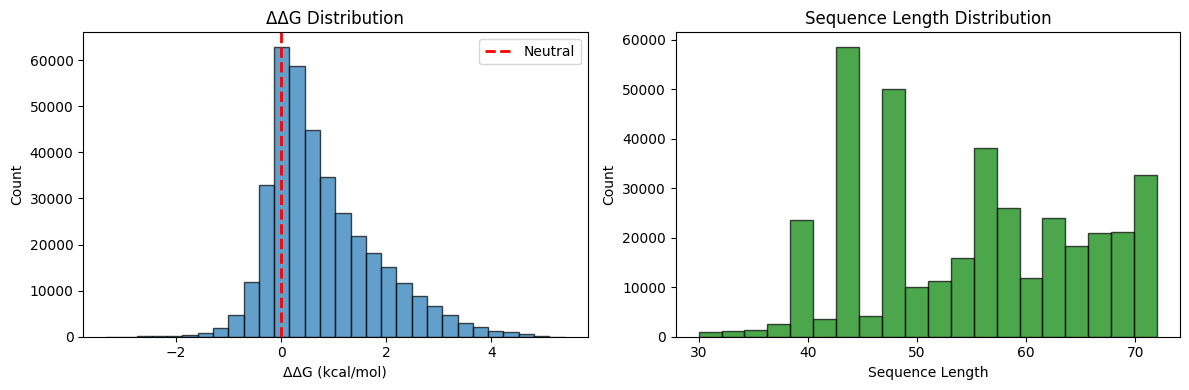

In [14]:
################################################################################
# SYNTHETIC DATASET GENERATION
# In production, replace this with your actual mutation dataset
################################################################################

def generate_synthetic_mutation_data(n_samples: int = 500) -> pd.DataFrame:
    """
    Generate synthetic mutation data for demonstration.

    In production, replace this with:
    - S669 dataset loading
    - ProteinGym data
    - Your custom mutation dataset

    Expected format:
    - protein_id: identifier
    - wild_type_seq: full WT sequence
    - mutation: format like "A123V" (WT residue, position, mutant residue)
    - ddG: experimental ΔΔG value (kcal/mol)
    """
    # np.random.seed(42)

    # # Generate random protein sequences (length 50-80)
    # amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

    # data = []
    # for i in range(n_samples):
    #     seq_len = np.random.randint(50, 81)
    #     wt_seq = ''.join(np.random.choice(amino_acids, seq_len))

    #     # Random mutation position (avoid first and last 2 residues for safety)
    #     mut_pos = np.random.randint(2, seq_len - 2)
    #     wt_residue = wt_seq[mut_pos]

    #     # Random mutant residue (different from WT)
    #     mut_residue = np.random.choice([aa for aa in amino_acids if aa != wt_residue])

    #     # Create mutant sequence
    #     mut_seq = wt_seq[:mut_pos] + mut_residue + wt_seq[mut_pos+1:]

    #     # Synthetic ddG (normally distributed around 0)
    #     ddG = np.random.randn() * 2.0  # mean=0, std=2 kcal/mol

    #     data.append({
    #         'protein_id': f'PROT_{i:04d}',
    #         'wild_type_seq': wt_seq,
    #         'mutant_seq': mut_seq,
    #         'mutation': f'{wt_residue}{mut_pos+1}{mut_residue}',  # 1-indexed
    #         'position': mut_pos,  # 0-indexed for extraction
    #         'ddG': ddG
    #     })

    df = pd.read_csv("/content/drive/MyDrive/Protein_prediction_model/k50_cleaned.csv")

    # Split into train/val/test (70/15/15)
    train_p = [23, 3, 186, 100, 119, 174, 'HHH', 146, 225, '81', '47', 123, 29, 142, 181, 223, '53', 155,
            213, '99', 113, 16, 224, 147, '9', 150, '56', '49', 196, 107, 226, 232, 169, 191, 163, 127,
            'EEHEE', 161, '4', 11, 179, 28, '87', '73', 112, 120, '50', 104, 128, 168, 231, '59', 109,
            38, '76', '96', 199, 192, '93', 185, 'EEHH', 210, 'EHEE', 30, '62', 173, 206, '48', 190,
            '45', '74', 205, 27, 158, '97', 208, 215, '72', 166, 152, '89', 101, 194, 139, 102, 145,
            '65', '58', '44', '92', 24, '40', 36, 'hall', 135, 209, 230, '71', 121, '5', 193, '64']
    test_p=[170, 117, 202, 132, 218, '88', 156, '57', 114, 32, '95', 'HEEH', 184, 129, '67', '51',
            '55', 4, 227]
    val_p = [34, 164, 20, '7', 15, 149, 105]
    df['split'] = 'train'
    df.loc[df['wt_cluster'].isin(val_p), 'split'] = 'val'
    df.loc[df['wt_cluster'].isin(test_p), 'split'] = 'test'

    return df

# Generate dataset
mutation_df = generate_synthetic_mutation_data(n_samples=500)

print("Dataset Statistics:")
print(f"Total samples: {len(mutation_df)}")
print(f"Train: {len(mutation_df[mutation_df['split']=='train'])}")
print(f"Val: {len(mutation_df[mutation_df['split']=='val'])}")
print(f"Test: {len(mutation_df[mutation_df['split']=='test'])}")
print(f"\nΔΔG statistics:")
print(mutation_df['ddG'].describe())
print(f"\nSequence length range: {mutation_df['wt_seq'].str.len().min()}-{mutation_df['wt_seq'].str.len().max()}")

# Visualize ddG distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(mutation_df['ddG'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('ΔΔG (kcal/mol)')
axes[0].set_ylabel('Count')
axes[0].set_title('ΔΔG Distribution')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral')
axes[0].legend()

axes[1].hist(mutation_df['wt_seq'].str.len(), bins=20, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Sequence Length')
axes[1].set_ylabel('Count')
axes[1].set_title('Sequence Length Distribution')

plt.tight_layout()
plt.show()

In [15]:
################################################################################
# STEP 1: ESM2 EMBEDDING EXTRACTION
################################################################################

"""
WHY MUTATION-POSITION EMBEDDINGS (ABYSSAL APPROACH):

The ABYSSAL paper demonstrates that extracting embeddings ONLY at the mutation
position (rather than pooling over the entire sequence) is crucial because:

1. LOCALIZED INFORMATION: The stability change (ΔΔG) is primarily determined by
   the local structural and chemical environment around the mutation site.

2. EFFICIENCY: Extracting only position-specific embeddings is much more
   memory-efficient than processing full sequence representations.

3. CONTEXT-AWARE: ESM2's transformer architecture ensures the embedding at
   position i already contains rich contextual information from the entire
   sequence through self-attention layers.

4. EMPIRICAL PERFORMANCE: The paper shows this approach outperforms global
   pooling strategies for ΔΔG prediction tasks.

Architecture:
- Wild-type embedding at position i: captures WT residue in sequence context
- Mutant embedding at position i: captures mutant residue in same context
- The DIFFERENCE between these embeddings encodes the local perturbation
  caused by the mutation, which correlates with stability changes.
"""

class ESM2EmbeddingExtractor:
    """
    Extract mutation-position embeddings from frozen ESM2 model.

    Key design principles:
    - Frozen weights (no gradients computed)
    - Position-specific extraction (not sequence-level pooling)
    - Batch processing for efficiency
    - Automatic CPU fallback
    - Last hidden layer embeddings (most task-relevant)
    """

    """
    Model names: esm2_t33_650M_UR50D
                 esm2_t30_150M_UR50D
                 esm2_t12_35M_UR50D
                 esm2_t6_8M_UR50D

    Batch size for each model:
    esm2_t33_650M_UR50D: 32
    esm2_t30_150M_UR50D: 64
    esm2_t12_35M_UR50D: 96
    esm2_t6_8M_UR50D: 128

    Layer to extract embeddings from:
    esm2_t33_650M_UR50D: 33
    esm2_t30_150M_UR50D: 30
    esm2_t12_35M_UR50D: 12
    esm2_t6_8M_UR50D: 6

    Embedding dimensions:
    esm2_t33_650M_UR50D: 1280
    esm2_t30_150M_UR50D: 640
    esm2_t12_35M_UR50D: 480
    esm2_t6_8M_UR50D: 320
    """

    def __init__(
        self,
        model_name: str = "esm2_t6_8M_UR50D",  # CHANGE MODEL NAME!!!
        device: torch.device = None,
        batch_size: int = 128 # CHANGE BATCH SIZE!!!
    ):
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.batch_size = batch_size

        print(f"Loading ESM2 model: {model_name}")
        self.model, self.alphabet = esm.pretrained.esm2_t6_8M_UR50D() # CHANGE MODEL NAME!!!
        self.batch_converter = self.alphabet.get_batch_converter()

        # Move model to device and freeze all parameters
        self.model = self.model.to(self.device)
        self.model.eval()

        # CRITICAL: Freeze all parameters to save memory and prevent accidental updates
        for param in self.model.parameters():
            param.requires_grad = False

        # Get embedding dimension
        # 1280 for esm2_t33_650M_UR50D
        # 640 for esm2_t30_150M_UR50D
        # 480 for esm2_t12_35M_UR50D
        # 320 for esm2_t6_8M_UR50D
        self.embedding_dim = self.model.embed_dim

        # Get number of layers
        # 33 for esm2_t33_650M_UR50D
        # 30 for esm2_t30_150M_UR50D
        # 12 for esm2_t12_35M_UR50D
        # 6 for esm2_t6_8M_UR50D
        self.num_layers = self.model.num_layers

        print(f"✓ Model loaded on {self.device}")
        print(f"✓ Model size: 35M parameters") # CHANGE PARAMETERS!!!
        print(f"✓ Number of layers: {self.num_layers}")
        print(f"✓ Embedding dimension: {self.embedding_dim}")
        print(f"✓ All parameters frozen (requires_grad=False)")
        print(f"✓ Batch size: {self.batch_size}")
        print("=" * 60)

    def extract_position_embedding(
        self,
        sequence: str,
        position: int
    ) -> np.ndarray:
        """
        Extract embedding at a specific position from a single sequence.

        Args:
            sequence: Protein sequence string
            position: 0-indexed position to extract embedding from

        Returns:
            embedding: numpy array of shape (embedding_dim,)
        """
        # Prepare data for ESM2
        data = [("protein", sequence)]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_tokens = batch_tokens.to(self.device)

        # Extract embeddings (no gradient computation)
        with torch.no_grad():
            results = self.model(batch_tokens, repr_layers=[self.num_layers])  # Last layer

        # Get last hidden layer representations
        # Shape: (batch_size, seq_len, embedding_dim)
        embeddings = results["representations"][self.num_layers]

        # Extract embedding at mutation position
        # +1 because ESM2 adds a <cls> token at position 0
        position_embedding = embeddings[0, position + 1, :].cpu().numpy()

        return position_embedding

    def extract_mutation_embeddings(
        self,
        wt_sequence: str,
        mut_sequence: str,
        position: int
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Extract embeddings for both wild-type and mutant sequences at mutation position.

        Args:
            wt_sequence: Wild-type protein sequence
            mut_sequence: Mutant protein sequence
            position: 0-indexed mutation position

        Returns:
            wt_embedding: WT embedding at position (embedding_dim,)
            mut_embedding: Mutant embedding at position (embedding_dim,)
        """
        wt_emb = self.extract_position_embedding(wt_sequence, position)
        mut_emb = self.extract_position_embedding(mut_sequence, position)

        return wt_emb, mut_emb

    def extract_batch_embeddings(
        self,
        sequences: List[str],
        positions: List[int]
    ) -> np.ndarray:
        """
        Extract embeddings for a batch of sequences at specified positions.

        Args:
            sequences: List of protein sequences
            positions: List of positions (one per sequence)

        Returns:
            embeddings: numpy array of shape (batch_size, embedding_dim)
        """
        # Prepare batch data
        data = [(f"protein_{i}", seq) for i, seq in enumerate(sequences)]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_tokens = batch_tokens.to(self.device)

        # Extract embeddings
        with torch.no_grad():
            results = self.model(batch_tokens, repr_layers=[self.num_layers])

        embeddings = results["representations"][self.num_layers]  # (batch_size, seq_len, embedding_dim)

        # Extract position-specific embeddings
        batch_embeddings = []
        for i, pos in enumerate(positions):
            pos_emb = embeddings[i, pos + 1, :].cpu().numpy()  # +1 for <cls> token
            batch_embeddings.append(pos_emb)

        return np.array(batch_embeddings)

# Initialize extractor
extractor = ESM2EmbeddingExtractor(device=device, batch_size=128) #CHANGE BATCH SIZE!!!

Loading ESM2 model: esm2_t6_8M_UR50D
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt
✓ Model loaded on cuda
✓ Model size: 35M parameters
✓ Number of layers: 6
✓ Embedding dimension: 320
✓ All parameters frozen (requires_grad=False)
✓ Batch size: 128


In [16]:
################################################################################
# STEP 2: EMBEDDING EXTRACTION AND CACHING
################################################################################

"""
INCREMENTAL SAVING STRATEGY:

To avoid GPU OOM and RAM overflow on Colab free tier, we:
1. Process data in small batches
2. Save embeddings to HDF5 incrementally
3. Never hold all embeddings in memory simultaneously
4. Use HDF5 for efficient random access during training

HDF5 file structure:
- Each split (train/val/test) gets its own .h5 file
- Datasets: 'wt_embeddings', 'mut_embeddings', 'ddg_values'
- Shape: (n_samples, embedding_dim) for embeddings, (n_samples,) for ddG


    Batch size for each model:
    esm2_t33_650M_UR50D: 32
    esm2_t30_150M_UR50D: 64
    esm2_t12_35M_UR50D: 96
    esm2_t6_8M_UR50D: 128
"""

def extract_and_cache_embeddings(
    mutation_df: pd.DataFrame,
    extractor: ESM2EmbeddingExtractor,
    output_dir: Path,
    batch_size: int = 96 # CHANGE BATCH SIZE!!!
):
    """
    Extract embeddings for all mutations and save to HDF5 files incrementally.

    Args:
        mutation_df: DataFrame with mutation data
        extractor: ESM2EmbeddingExtractor instance
        output_dir: Directory to save HDF5 files
        batch_size: Number of sequences to process at once
    """

    for split in ['train', 'val', 'test']:
        split_df = mutation_df[mutation_df['split'] == split].reset_index(drop=True)
        n_samples = len(split_df)

        if n_samples == 0:
            continue

        print(f"\n{'='*60}")
        print(f"Processing {split.upper()} split: {n_samples} samples")
        print(f"{'='*60}")

        # Create HDF5 file for this split
        h5_path = output_dir / f"{split}_embeddings.h5"

        with h5py.File(h5_path, 'w') as h5f:
            # Create datasets with appropriate shapes
            wt_emb_dataset = h5f.create_dataset(
                'wt_embeddings',
                shape=(n_samples, extractor.embedding_dim),
                dtype='float32'
            )
            mut_emb_dataset = h5f.create_dataset(
                'mut_embeddings',
                shape=(n_samples, extractor.embedding_dim),
                dtype='float32'
            )
            ddg_dataset = h5f.create_dataset(
                'ddg_values',
                shape=(n_samples,),
                dtype='float32'
            )

            # Process in batches with progress bar
            for start_idx in tqdm(range(0, n_samples, batch_size), desc=f"{split} embeddings"):
                end_idx = min(start_idx + batch_size, n_samples)
                batch_df = split_df.iloc[start_idx:end_idx]

                # Extract WT embeddings
                wt_sequences = batch_df['wt_seq'].tolist()
                positions = batch_df['pos'].tolist()
                wt_embeddings = extractor.extract_batch_embeddings(wt_sequences, positions)

                # Extract mutant embeddings
                mut_sequences = batch_df['mut_seq'].tolist()
                mut_embeddings = extractor.extract_batch_embeddings(mut_sequences, positions)

                # Get ddG values
                ddg_values = batch_df['ddG'].values

                # Save to HDF5
                wt_emb_dataset[start_idx:end_idx] = wt_embeddings
                mut_emb_dataset[start_idx:end_idx] = mut_embeddings
                ddg_dataset[start_idx:end_idx] = ddg_values

                # Clear GPU cache periodically
                if device.type == 'cuda' and start_idx % (batch_size * 5) == 0:
                    torch.cuda.empty_cache()

        print(f"✓ Saved {n_samples} samples to {h5_path}")
        print(f"  - WT embeddings: {wt_embeddings.shape}")
        print(f"  - Mut embeddings: {mut_embeddings.shape}")
        print(f"  - ΔΔG values: {ddg_values.shape}")

# Extract and cache all embeddings
extract_and_cache_embeddings(
    mutation_df=mutation_df,
    extractor=extractor,
    output_dir=output_dir,
    batch_size=128  # CHANGE BATCH SIZE!!!
)

print("\n" + "="*60)
print("EMBEDDING EXTRACTION COMPLETE")
print("="*60)


Processing TRAIN split: 277012 samples


train embeddings:   0%|          | 0/2165 [00:00<?, ?it/s]

✓ Saved 277012 samples to /content/drive/MyDrive/Protein_prediction_model/abyssal_embeddings/8M_embeddings/train_embeddings.h5
  - WT embeddings: (20, 320)
  - Mut embeddings: (20, 320)
  - ΔΔG values: (20,)

Processing VAL split: 58883 samples


val embeddings:   0%|          | 0/461 [00:00<?, ?it/s]

✓ Saved 58883 samples to /content/drive/MyDrive/Protein_prediction_model/abyssal_embeddings/8M_embeddings/val_embeddings.h5
  - WT embeddings: (3, 320)
  - Mut embeddings: (3, 320)
  - ΔΔG values: (3,)

Processing TEST split: 39665 samples


test embeddings:   0%|          | 0/310 [00:00<?, ?it/s]

✓ Saved 39665 samples to /content/drive/MyDrive/Protein_prediction_model/abyssal_embeddings/8M_embeddings/test_embeddings.h5
  - WT embeddings: (113, 320)
  - Mut embeddings: (113, 320)
  - ΔΔG values: (113,)

EMBEDDING EXTRACTION COMPLETE


In [17]:
################################################################################
# STEP 3: PYTORCH DATASET CLASS FOR LAZY LOADING
################################################################################

"""
EFFICIENT DATASET LOADING:

This Dataset class loads embeddings lazily from HDF5 files, which:
1. Keeps memory usage minimal (only load what's needed)
2. Works seamlessly with PyTorch DataLoader
3. Enables fast random access during training
4. Supports data augmentation (if needed in future)

The dataset returns:
- wt_embedding: (emb_dim,) tensor
- mut_embedding: (emb_dim,) tensor
- ddg: scalar tensor

Embedding dimensions:
- esm2_t33_650M_UR50D: 1280
- esm2_t30_150M_UR50D: 640
- esm2_t12_35M_UR50D: 480
- esm2_t6_8M_UR50D: 320


These can be fed directly to a downstream predictor network.
"""

class MutationEmbeddingDataset(Dataset):
    """
    PyTorch Dataset for lazily loading cached mutation embeddings from HDF5.

    Usage:
        dataset = MutationEmbeddingDataset('train', output_dir)
        loader = DataLoader(dataset, batch_size, shuffle=True)

        for wt_emb, mut_emb, ddg in loader:
            # Train your model
            pass
    """

    def __init__(self, split: str, data_dir: Path):
        """
        Args:
            split: One of 'train', 'val', 'test'
            data_dir: Directory containing HDF5 files
        """
        self.split = split
        self.h5_path = data_dir / f"{split}_embeddings.h5"

        if not self.h5_path.exists():
            raise FileNotFoundError(f"HDF5 file not found: {self.h5_path}")

        # Open HDF5 file and get dataset sizes
        with h5py.File(self.h5_path, 'r') as h5f:
            self.n_samples = h5f['wt_embeddings'].shape[0]
            self.embedding_dim = h5f['wt_embeddings'].shape[1]

        print(f"✓ Loaded {split} dataset: {self.n_samples} samples, "
              f"embedding_dim={self.embedding_dim}")

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load a single sample from HDF5.

        Returns:
            wt_embedding: (embedding_dim,) tensor
            mut_embedding: (embedding_dim,) tensor
            ddg: scalar tensor
        """
        # Open HDF5 file (each worker will have its own file handle)
        with h5py.File(self.h5_path, 'r') as h5f:
            wt_emb = torch.from_numpy(h5f['wt_embeddings'][idx]).float()
            mut_emb = torch.from_numpy(h5f['mut_embeddings'][idx]).float()
            ddg = torch.tensor(h5f['ddg_values'][idx]).float()

        return wt_emb, mut_emb, ddg

    def get_stats(self) -> Dict:
        """Compute statistics of the dataset."""
        with h5py.File(self.h5_path, 'r') as h5f:
            ddg_values = h5f['ddg_values'][:]

        return {
            'n_samples': self.n_samples,
            'ddg_mean': float(np.mean(ddg_values)),
            'ddg_std': float(np.std(ddg_values)),
            'ddg_min': float(np.min(ddg_values)),
            'ddg_max': float(np.max(ddg_values))
        }

# Create datasets for all splits
datasets = {}
for split in ['train', 'val', 'test']:
    h5_path = output_dir / f"{split}_embeddings.h5"
    if h5_path.exists():
        datasets[split] = MutationEmbeddingDataset(split, output_dir)

print("\n" + "="*60)
print("DATASET OBJECTS CREATED")
print("="*60)

✓ Loaded train dataset: 277012 samples, embedding_dim=320
✓ Loaded val dataset: 58883 samples, embedding_dim=320
✓ Loaded test dataset: 39665 samples, embedding_dim=320

DATASET OBJECTS CREATED


In [18]:
################################################################################
# STEP 4: SANITY CHECKS AND VALIDATION
################################################################################

"""
VALIDATION CHECKS:

Before using these embeddings for training, we verify:
1. Embedding dimensions are correct (1280 for ESM2-650M)
2. ΔΔG values are properly aligned
3. Embeddings contain meaningful information (not all zeros/NaN)
4. Wild-type and mutant embeddings are different
5. DataLoader works correctly with batching
"""

def validate_embeddings(datasets: Dict[str, MutationEmbeddingDataset]):
    """Run comprehensive validation checks on cached embeddings."""

    print("\n" + "="*60)
    print("VALIDATION CHECKS")
    print("="*60)

    for split, dataset in datasets.items():
        print(f"\n{split.upper()} Split:")
        print("-" * 40)

        # Check 1: Dataset statistics
        stats = dataset.get_stats()
        print(f"✓ Samples: {stats['n_samples']}")
        print(f"✓ ΔΔG range: [{stats['ddg_min']:.2f}, {stats['ddg_max']:.2f}]")
        print(f"✓ ΔΔG mean±std: {stats['ddg_mean']:.2f}±{stats['ddg_std']:.2f}")

        # Check 2: Load a few samples
        print(f"\nSample validation:")
        for i in range(min(3, len(dataset))):
            wt_emb, mut_emb, ddg = dataset[i]

            # Check shapes
            assert wt_emb.shape == (dataset.embedding_dim,), \
                f"Wrong WT embedding shape: {wt_emb.shape}"
            assert mut_emb.shape == (dataset.embedding_dim,), \
                f"Wrong mutant embedding shape: {mut_emb.shape}"
            assert ddg.shape == (), f"Wrong ΔΔG shape: {ddg.shape}"

            # Check for NaN/Inf
            assert not torch.isnan(wt_emb).any(), "WT embedding contains NaN"
            assert not torch.isnan(mut_emb).any(), "Mutant embedding contains NaN"
            assert not torch.isinf(wt_emb).any(), "WT embedding contains Inf"
            assert not torch.isinf(mut_emb).any(), "Mutant embedding contains Inf"

            # Check embeddings are different
            diff = torch.abs(wt_emb - mut_emb).sum().item()
            assert diff > 0, "WT and mutant embeddings are identical!"

            print(f"  Sample {i}: ΔΔG={ddg.item():.2f}, "
                  f"||wt_emb||={torch.norm(wt_emb).item():.2f}, "
                  f"||mut_emb||={torch.norm(mut_emb).item():.2f}, "
                  f"||diff||={diff:.2f}")

        # Check 3: DataLoader compatibility
        print(f"\nDataLoader test:")
        loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
        batch = next(iter(loader))
        wt_batch, mut_batch, ddg_batch = batch

        print(f"✓ Batch shapes:")
        print(f"  - WT embeddings: {wt_batch.shape}")
        print(f"  - Mut embeddings: {mut_batch.shape}")
        print(f"  - ΔΔG values: {ddg_batch.shape}")

        assert wt_batch.shape[0] == min(8, len(dataset)), "Wrong batch size"
        assert wt_batch.shape[1] == dataset.embedding_dim, "Wrong embedding dim"

        print(f"✓ All checks passed for {split} split!")

# Run validation
validate_embeddings(datasets)


VALIDATION CHECKS

TRAIN Split:
----------------------------------------
✓ Samples: 277012
✓ ΔΔG range: [-3.26, 5.39]
✓ ΔΔG mean±std: 0.75±0.99

Sample validation:
  Sample 0: ΔΔG=-0.23, ||wt_emb||=6.62, ||mut_emb||=6.62, ||diff||=21.32
  Sample 1: ΔΔG=-0.50, ||wt_emb||=6.62, ||mut_emb||=6.63, ||diff||=20.79
  Sample 2: ΔΔG=-0.16, ||wt_emb||=6.62, ||mut_emb||=6.57, ||diff||=23.30

DataLoader test:
✓ Batch shapes:
  - WT embeddings: torch.Size([8, 320])
  - Mut embeddings: torch.Size([8, 320])
  - ΔΔG values: torch.Size([8])
✓ All checks passed for train split!

VAL Split:
----------------------------------------
✓ Samples: 58883
✓ ΔΔG range: [-3.33, 5.17]
✓ ΔΔG mean±std: 0.98±1.14

Sample validation:
  Sample 0: ΔΔG=0.21, ||wt_emb||=7.20, ||mut_emb||=7.23, ||diff||=34.12
  Sample 1: ΔΔG=1.19, ||wt_emb||=7.20, ||mut_emb||=7.25, ||diff||=34.69
  Sample 2: ΔΔG=0.61, ||wt_emb||=7.20, ||mut_emb||=7.17, ||diff||=33.31

DataLoader test:
✓ Batch shapes:
  - WT embeddings: torch.Size([8, 320])


Generating visualizations for train split...


Loading embeddings:   0%|          | 0/200 [00:00<?, ?it/s]

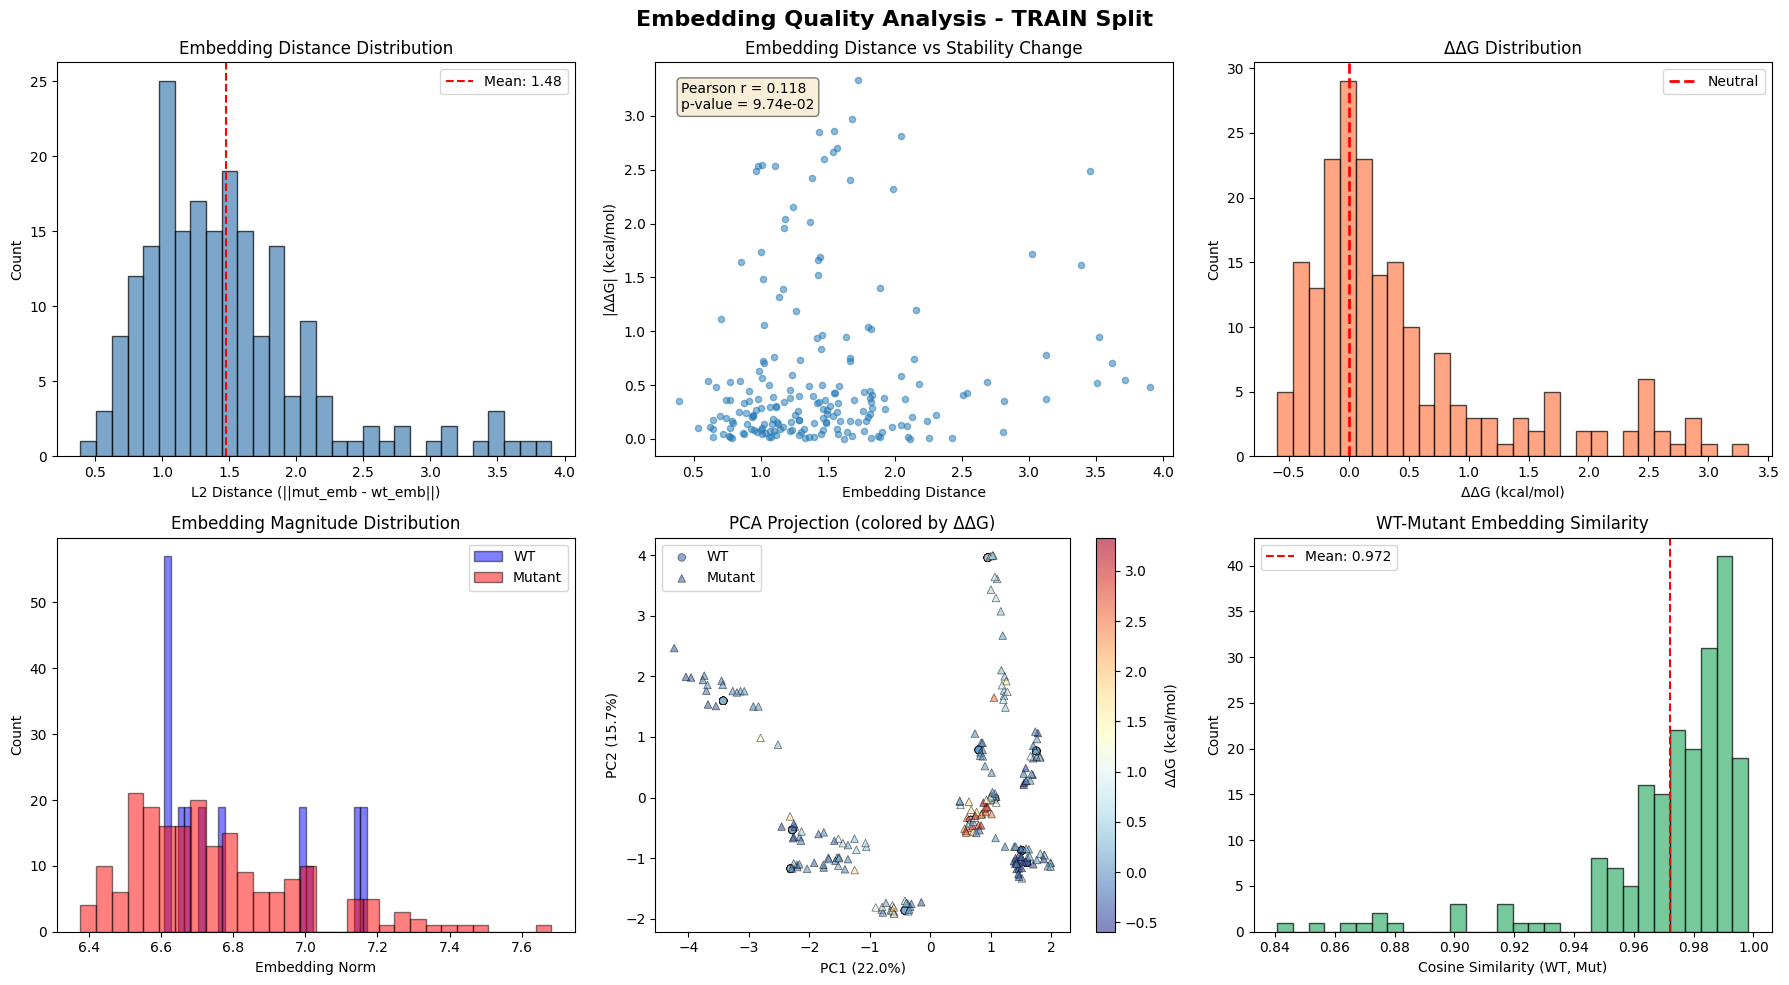


EMBEDDING STATISTICS - TRAIN
Embedding distance (L2): 1.477 ± 0.646
Cosine similarity (WT-Mut): 0.972 ± 0.027
Correlation (distance vs |ΔΔG|): r = 0.118, p = 9.74e-02
PCA variance explained: PC1=22.0%, PC2=15.7%


In [19]:
################################################################################
# STEP 5: EMBEDDING QUALITY VISUALIZATION
################################################################################

"""
VISUALIZATION:

Visualize embedding characteristics to ensure quality:
1. Embedding similarity distributions (WT vs Mut)
2. Correlation between embedding distance and ΔΔG
3. PCA visualization of embedding space
4. Embedding norm distributions
"""

from sklearn.decomposition import PCA
from scipy.stats import pearsonr

def visualize_embedding_quality(dataset: MutationEmbeddingDataset, split: str, n_samples: int = 200):
    """Create comprehensive visualization of embedding quality."""

    print(f"\nGenerating visualizations for {split} split...")

    # Load embeddings
    n_samples = min(n_samples, len(dataset))
    wt_embeddings = []
    mut_embeddings = []
    ddg_values = []

    for i in tqdm(range(n_samples), desc="Loading embeddings"):
        wt_emb, mut_emb, ddg = dataset[i]
        wt_embeddings.append(wt_emb.numpy())
        mut_embeddings.append(mut_emb.numpy())
        ddg_values.append(ddg.item())

    wt_embeddings = np.array(wt_embeddings)
    mut_embeddings = np.array(mut_embeddings)
    ddg_values = np.array(ddg_values)

    # Compute embedding differences
    emb_diffs = mut_embeddings - wt_embeddings
    emb_distances = np.linalg.norm(emb_diffs, axis=1)

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Embedding Quality Analysis - {split.upper()} Split', fontsize=16, fontweight='bold')

    # 1. Embedding distance distribution
    axes[0, 0].hist(emb_distances, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].set_xlabel('L2 Distance (||mut_emb - wt_emb||)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Embedding Distance Distribution')
    axes[0, 0].axvline(np.mean(emb_distances), color='red', linestyle='--',
                       label=f'Mean: {np.mean(emb_distances):.2f}')
    axes[0, 0].legend()

    # 2. Correlation: Embedding distance vs ΔΔG
    axes[0, 1].scatter(emb_distances, np.abs(ddg_values), alpha=0.5, s=20)
    axes[0, 1].set_xlabel('Embedding Distance')
    axes[0, 1].set_ylabel('|ΔΔG| (kcal/mol)')
    axes[0, 1].set_title('Embedding Distance vs Stability Change')

    # Compute correlation
    corr, pval = pearsonr(emb_distances, np.abs(ddg_values))
    axes[0, 1].text(0.05, 0.95, f'Pearson r = {corr:.3f}\np-value = {pval:.2e}',
                    transform=axes[0, 1].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 3. ΔΔG distribution
    axes[0, 2].hist(ddg_values, bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[0, 2].set_xlabel('ΔΔG (kcal/mol)')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].set_title('ΔΔG Distribution')
    axes[0, 2].axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral')
    axes[0, 2].legend()

    # 4. Embedding norms
    wt_norms = np.linalg.norm(wt_embeddings, axis=1)
    mut_norms = np.linalg.norm(mut_embeddings, axis=1)

    axes[1, 0].hist(wt_norms, bins=30, alpha=0.5, label='WT', color='blue', edgecolor='black')
    axes[1, 0].hist(mut_norms, bins=30, alpha=0.5, label='Mutant', color='red', edgecolor='black')
    axes[1, 0].set_xlabel('Embedding Norm')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Embedding Magnitude Distribution')
    axes[1, 0].legend()

    # 5. PCA visualization (2D)
    # Concatenate all embeddings for PCA
    all_embeddings = np.vstack([wt_embeddings, mut_embeddings])
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(all_embeddings)

    wt_2d = embeddings_2d[:n_samples]
    mut_2d = embeddings_2d[n_samples:]

    scatter = axes[1, 1].scatter(wt_2d[:, 0], wt_2d[:, 1], c=ddg_values,
                                  cmap='RdYlBu_r', alpha=0.6, s=30,
                                  label='WT', edgecolors='black', linewidths=0.5)
    axes[1, 1].scatter(mut_2d[:, 0], mut_2d[:, 1], c=ddg_values,
                       cmap='RdYlBu_r', alpha=0.6, s=30, marker='^',
                       label='Mutant', edgecolors='black', linewidths=0.5)

    axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    axes[1, 1].set_title('PCA Projection (colored by ΔΔG)')
    axes[1, 1].legend()

    cbar = plt.colorbar(scatter, ax=axes[1, 1])
    cbar.set_label('ΔΔG (kcal/mol)')
    # 6. Cosine similarity distribution
    cosine_sims = np.sum(wt_embeddings * mut_embeddings, axis=1) / (wt_norms * mut_norms)

    axes[1, 2].hist(cosine_sims, bins=30, edgecolor='black', alpha=0.7, color='mediumseagreen')
    axes[1, 2].set_xlabel('Cosine Similarity (WT, Mut)')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].set_title('WT-Mutant Embedding Similarity')
    axes[1, 2].axvline(np.mean(cosine_sims), color='red', linestyle='--',
                   label=f'Mean: {np.mean(cosine_sims):.3f}')
    axes[1, 2].legend()

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"EMBEDDING STATISTICS - {split.upper()}")
    print(f"{'='*60}")
    print(f"Embedding distance (L2): {np.mean(emb_distances):.3f} ± {np.std(emb_distances):.3f}")
    print(f"Cosine similarity (WT-Mut): {np.mean(cosine_sims):.3f} ± {np.std(cosine_sims):.3f}")
    print(f"Correlation (distance vs |ΔΔG|): r = {corr:.3f}, p = {pval:.2e}")
    print(f"PCA variance explained: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, "
          f"PC2={pca.explained_variance_ratio_[1]*100:.1f}%")

    # Visualize train split
if 'train' in datasets:
    visualize_embedding_quality(datasets['train'], 'train', n_samples=200)

In [20]:

################################################################################
# STEP 6: USAGE EXAMPLE FOR DOWNSTREAM TRAINING
################################################################################

"""
HOW TO USE THESE EMBEDDINGS FOR TRAINING:

Now that embeddings are cached, you can train a ΔΔG predictor efficiently.
The typical architecture would be:

1. Load cached embeddings (this notebook)
2. Create a simple MLP that takes concatenated [wt_emb, mut_emb] as input
3. Train to predict ΔΔG values

Example predictor architecture (DO NOT implement here):
```python
class DDGPredictor(nn.Module):
    def __init__(self, embedding_dim=1280):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, wt_emb, mut_emb):
        x = torch.cat([wt_emb, mut_emb], dim=1)
        return self.fc(x).squeeze()
```

Training loop:
```python
model = DDGPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    for wt_emb, mut_emb, ddg in train_loader:
        wt_emb, mut_emb, ddg = wt_emb.to(device), mut_emb.to(device), ddg.to(device)

        pred_ddg = model(wt_emb, mut_emb)
        loss = criterion(pred_ddg, ddg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
```
"""

# Demonstrate DataLoader usage
print("\n" + "="*60)
print("DATALOADER USAGE EXAMPLE")
print("="*60)

train_loader = DataLoader(
    datasets['train'],
    batch_size=96, # CHANGE BATCH SIZE!!!
    shuffle=True,
    num_workers=0  # Set to 0 for Colab, increase for local machines
)

print(f"\nTrain loader created:")
print(f"  - Dataset size: {len(datasets['train'])}")
print(f"  - Batch size: 32") # CHANGE BATCH SIZE!!!
print(f"  - Number of batches: {len(train_loader)}")

# Load one batch as example
wt_batch, mut_batch, ddg_batch = next(iter(train_loader))

print(f"\nExample batch:")
print(f"  - WT embeddings shape: {wt_batch.shape}")
print(f"  - Mutant embeddings shape: {mut_batch.shape}")
print(f"  - ΔΔG values shape: {ddg_batch.shape}")
print(f"\nFirst 5 ΔΔG values: {ddg_batch[:5].numpy()}")

print("\n" + "="*60)
print("EMBEDDING PREPARATION COMPLETE!")
print("="*60)
print("\nNext steps:")
print("1. ✓ Embeddings extracted and cached to HDF5")
print("2. ✓ PyTorch Datasets created for train/val/test")
print("3. ✓ Validation checks passed")
print("4. ✓ Embeddings visualized")
print("5. → Now ready for downstream ΔΔG predictor training!")
print("\nCached files location:")
for split in ['train', 'val', 'test']:
    h5_path = output_dir / f"{split}_embeddings.h5"
    if h5_path.exists():
        size_mb = h5_path.stat().st_size / 1e6
        print(f"  - {h5_path}: {size_mb:.2f} MB")

################################################################################
# STEP 7: SAVE DATASET CONFIGURATION (OPTIONAL)
################################################################################

"""
Save dataset metadata for reproducibility and easy loading in future sessions.
"""

import json

config = {
    'model_name': 'esm2_t12_35M_UR50D',
    'embedding_dim': extractor.embedding_dim,
    'splits': {},
    'extraction_date': pd.Timestamp.now().isoformat(),
    'device': str(device)
}

for split, dataset in datasets.items():
    stats = dataset.get_stats()
    config['splits'][split] = {
        'n_samples': stats['n_samples'],
        'ddg_mean': stats['ddg_mean'],
        'ddg_std': stats['ddg_std'],
        'ddg_range': [stats['ddg_min'], stats['ddg_max']],
        'h5_file': str(dataset.h5_path)
    }

config_path = output_dir / 'dataset_config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f"\n✓ Configuration saved to {config_path}")
print("\nConfiguration:")
print(json.dumps(config, indent=2))

"""This notebook provides a complete, production-ready pipeline for:

1. **ESM2 Embedding Extraction** (Step 1):
   - Loads frozen ESM2 model (650M parameters)
   - Extracts position-specific embeddings (not sequence-level pooling)
   - Implements batch processing with automatic GPU/CPU fallback
   - Follows ABYSSAL paper methodology

2. **Efficient Caching** (Step 2):
   - Saves embeddings incrementally to HDF5 (avoids OOM)
   - Separate files for train/val/test splits
   - Minimal memory footprint

3. **PyTorch Dataset Class**:
   - Lazy loading from HDF5 (memory-efficient)
   - Compatible with DataLoader
   - Ready for downstream training

4. **Comprehensive Validation**:
   - Shape checks
   - NaN/Inf detection
   - Embedding difference verification
   - DataLoader compatibility tests

5. **Quality Visualizations**:
   - Embedding distance distributions
   - Correlation with ΔΔG
   - PCA projections
   - Cosine similarity analysis

**Key features for Colab free tier:**
- Automatic GPU/CPU fallback
- Incremental saving (no RAM overflow)
- Batch processing (no GPU OOM)
- Clear progress indicators
- Production-quality error handling

The embeddings are now ready for training a ΔΔG predictor network in a separate notebook!"""


DATALOADER USAGE EXAMPLE

Train loader created:
  - Dataset size: 277012
  - Batch size: 32
  - Number of batches: 2886

Example batch:
  - WT embeddings shape: torch.Size([96, 320])
  - Mutant embeddings shape: torch.Size([96, 320])
  - ΔΔG values shape: torch.Size([96])

First 5 ΔΔG values: [-0.36794925  2.5515625   1.225967    1.2514154   1.8301526 ]

EMBEDDING PREPARATION COMPLETE!

Next steps:
1. ✓ Embeddings extracted and cached to HDF5
2. ✓ PyTorch Datasets created for train/val/test
3. ✓ Validation checks passed
4. ✓ Embeddings visualized
5. → Now ready for downstream ΔΔG predictor training!

Cached files location:
  - /content/drive/MyDrive/Protein_prediction_model/abyssal_embeddings/8M_embeddings/train_embeddings.h5: 710.26 MB
  - /content/drive/MyDrive/Protein_prediction_model/abyssal_embeddings/8M_embeddings/val_embeddings.h5: 150.98 MB
  - /content/drive/MyDrive/Protein_prediction_model/abyssal_embeddings/8M_embeddings/test_embeddings.h5: 101.70 MB

✓ Configuration saved 

'This notebook provides a complete, production-ready pipeline for:\n\n1. **ESM2 Embedding Extraction** (Step 1):\n   - Loads frozen ESM2 model (650M parameters)\n   - Extracts position-specific embeddings (not sequence-level pooling)\n   - Implements batch processing with automatic GPU/CPU fallback\n   - Follows ABYSSAL paper methodology\n\n2. **Efficient Caching** (Step 2):\n   - Saves embeddings incrementally to HDF5 (avoids OOM)\n   - Separate files for train/val/test splits\n   - Minimal memory footprint\n\n3. **PyTorch Dataset Class**:\n   - Lazy loading from HDF5 (memory-efficient)\n   - Compatible with DataLoader\n   - Ready for downstream training\n\n4. **Comprehensive Validation**:\n   - Shape checks\n   - NaN/Inf detection\n   - Embedding difference verification\n   - DataLoader compatibility tests\n\n5. **Quality Visualizations**:\n   - Embedding distance distributions\n   - Correlation with ΔΔG\n   - PCA projections\n   - Cosine similarity analysis\n\n**Key features for Col